***Deep Learning Assignment 1***

Perceptron Learning with Sigmoidal Activation Function on Linear Separable Data

Giving permission to read data from drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing libraries**

In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from itertools import permutations 
from scipy import stats

In [6]:
class ReadData(object):
    
    def __init__(self, data, filepath, files):
        
        files = [filepath + '/' + file for file in files]
        self.files = files
        
        for i in range(len(files)):
            
            class_i = pd.read_csv(files[i], sep = ' ', header = None)
            data.append(class_i.values)
            
        self.data = data

        
    def kClass(self, k):
        return self.data[k]  


    def plotData(self):
        
        for i in range(len(self.files)):
            class_label = 'Class' + str(i+1)
            plt.scatter(self.kClass(i)[:,0], self.kClass(i)[:,1], label = class_label)

        plt.legend()    
        plt.show() 


    def train_validation_test_split(self, perTrain, perVal, perTest):
        
        train_data = []
        val_data = []
        test_data = []
        
        n = len(self.files)
        
        for i in range(n):
            
            train, test = train_test_split(self.kClass(i), test_size=perTest, random_state=42, shuffle=True)
            train, val = train_test_split(train, test_size = (perVal/(perVal + perTrain)), random_state=42, shuffle=True)
            
            train_data.append(train)
            val_data.append(val)
            test_data.append(test)
            
        return train_data, val_data, test_data

In [7]:
class Perceptron(object):
    
    def __init__(self, weights, dim, actFun):
        
        self.dim = dim
        init_weights = np.random.normal(0, 1, dim+1)
        self.weights = init_weights
        self.actFun = actFun
        
        
    def fitTwo(self, trainData, lrRate, β, epochs):
        
        if(self.actFun == 'logistic' or self.actFun == 'tanh'):
            avgErrors = []
        else:
            print('Error\nActivation Function Not Available\nUse either logistic or tanh')
            return 
    
        
        for i in range(epochs):
            
            avgError = 0
            
            for k in range(2):
                
                l = len(trainData[k])
                o = np.ones(l)
                o = np.reshape(o, (l, 1))
                dt = np.hstack((o, trainData[k]))
                
                
                for j in range(l):
                    
                    a = np.sum(self.weights*dt[j])
                    
                    if(self.actFun == 'logistic'):
                        
                        s = 1/(1 + np.exp(-β*a))
                        e = np.sum(0.5*((k-s)**2))
                        
                        δw = lrRate*(k-s)*β*s*(1-s)*dt[j]
                        
                    elif(self.actFun == 'tanh'):
                        
                        x = np.exp(β*a)
                        y = np.exp(-β*a)
                        s = (x-y)/(x+y)
                        
                        e = np.sum(0.5*((k-s)**2))
                        
                        δw = lrRate*(k-s)*β*(1 - s**2)*dt[j]
                    
                        
                    self.weights += δw
                    avgError += e
                
            avgErrors.append(avgError)
                    
        plt.plot(list(range(1, epochs + 1, 1)), avgErrors)
        plt.title('Epochs vs Avg Error')
        plt.show()
        
        return self.weights

In [79]:
class MultiPerceptrons(object):
    
    def __init__(self, weights, dim, actFun):
        
        self.dim = dim
        init_weights = np.random.normal(0, 1, dim+1)
        self.weights = init_weights
        self.actFun = actFun
        
        
    def lexicographical_permutation(self, k): 
    
        string = ''
    
        for i in range(k):
            string = string + str(i)
        
        perm = sorted(''.join(chars) for chars in permutations(string)) 
        ans = []
        for x in perm: 
            a = (int(x[0]), int(x[1]))
            ans.append(tuple(sorted(a)))
        
        return set(ans)
        
        
    def fit(self, trainData, η, β, epochs, N):

        self.beta = β
        
        K = int(N*(N-1)/2)
        W = [[0 for x in range(N)] for x in range(N)] 
        
        ans = self.lexicographical_permutation(K)
        
        for i in ans:
            
            print('For Classes', i[0], i[1])
            
            perceptron = Perceptron(self.weights, self.dim, self.actFun)
            w = perceptron.fitTwo([trainData[i[0]], trainData[i[1]]], η, β, epochs)
            
            W[i[0]][i[1]] = w
            W[i[1]][i[0]] = w
            
            
        return W


    def logistic(self, x):
        return 1/(1 + np.exp(-self.beta*x))
    
    def tanh(self, x):
        return (np.exp(self.beta*x) - np.exp(-self.beta*x))/(np.exp(self.beta*x) + np.exp(-self.beta*x))
    
    
    def accuracy(self, finalWeights, data, N):
        
        if(self.actFun == 'logistic'):
            
            truePredCount = 0
            total_count = 0
            
            for k in range(N):
    
                labels = []
    
                l = len(data[k])
                o = np.ones(l)
                o = np.reshape(o, (l, 1))
                dt = np.hstack((o, data[k]))
                total_count += l
    
                for i in range(N):
                    for j in range(N):
                        if(i < j):
                
                            A = np.multiply(self.logistic(np.sum(finalWeights[i][j]*dt, axis = 1)) > 0.5, j+1)
                            A += np.multiply(self.logistic(np.sum(finalWeights[i][j]*dt, axis = 1)) <= 0.5, i+1)
                            A = np.reshape(A, (l, 1))
                
                            if(labels == []):
                                labels = A
                    
                            else:
                                labels = np.hstack((labels, A))   
                    
                preds = stats.mode(labels, axis = 1)[0]          
                truePredCount += np.sum(np.multiply(preds == k+1, 1))
    
            return (truePredCount/total_count)*100
        
        elif(self.actFun == 'tanh'):
            
            truePredCount = 0
            total_count = 0
            
            for k in range(N):
    
                labels = []
    
                l = len(data[k])
                o = np.ones(l)
                o = np.reshape(o, (l, 1))
                dt = np.hstack((o, data[k]))
                total_count += l
    
                for i in range(N):
                    for j in range(N):
                        if(i < j):
                
                            A = np.multiply(self.tanh(np.sum(finalWeights[i][j]*dt, axis = 1)) > 0, j+1)
                            A += np.multiply(self.tanh(np.sum(finalWeights[i][j]*dt, axis = 1)) <= 0, i+1)
                            A = np.reshape(A, (l, 1))
                
                            if(labels == []):
                                labels = A
                    
                            else:
                                labels = np.hstack((labels, A))   
                    
                preds = stats.mode(labels, axis = 1)[0]          
                truePredCount += np.sum(np.multiply(preds == k+1, 1))
    
            return (truePredCount/total_count)*100

    def decisionPlot(self, finalWeights, min, max, N, trainData):
        
        x = np.arange(min, max, 0.1)
        y = np.arange(min, max, 0.1)
        xx, yy = np.meshgrid(x, y)
        l = len(x)*len(x)
        o = np.ones(l)
        o = np.reshape(o, (l, 1))
        dt = np.hstack((np.reshape(xx, (l, 1)), np.reshape(yy, (l, 1))))
        dt = np.hstack((o, dt))

        labels = []

        for i in range(N):
            for j in range(N):
                if(i < j):

                    if(self.actFun == 'logistic'):
                        A = np.multiply(self.logistic(np.sum(finalWeights[i][j]*dt, axis = 1)) > 0.5, j+1)
                        A += np.multiply(self.logistic(np.sum(finalWeights[i][j]*dt, axis = 1)) <= 0.5, i+1)

                    elif(self.actFun == 'tanh'):
                        A = np.multiply(self.tanh(np.sum(finalWeights[i][j]*dt, axis = 1)) > 0, j+1)
                        A += np.multiply(self.tanh(np.sum(finalWeights[i][j]*dt, axis = 1)) <= 0, i+1)

                    A = np.reshape(A, (l, 1))
                
                    if(labels == []):
                        labels = A
                    
                    else:
                        labels = np.hstack((labels, A))   
                    
        preds = stats.mode(labels, axis = 1)[0]
        plt.scatter(dt[:,1],dt[:,2], c = preds, alpha = 0.1)

        for i in range(N):
            plt.scatter(trainData[i][:,0], trainData[i][:,1], s = 1)
            
        plt.show()

In [9]:
data = []
filenames = ['Class1.txt', 'Class2.txt', 'Class3.txt']
dataset = ReadData(data, '/content/drive/MyDrive/Group17/Classification/LS_Group17', filenames)

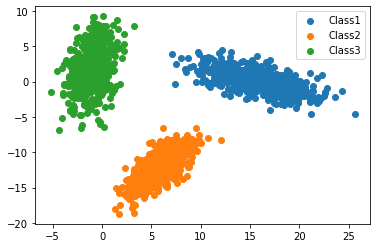

In [57]:
dataset.plotData()

In [58]:
trainData, valData, testData = dataset.train_validation_test_split(0.6,0.2,0.2)

In [80]:
weights = []
multiPerceptron = MultiPerceptrons(weights, 2, 'tanh')

****Best Accuracy comes in logistic function with learning rate = 0.4 and beta = 0.3
For tanh function, accuracy is difficult to be achieved to 100% but 80% can be achieved with learning rate = 0.01 and beta = 0.035****

For Classes 0 1


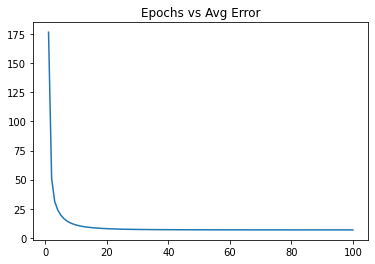

For Classes 0 2


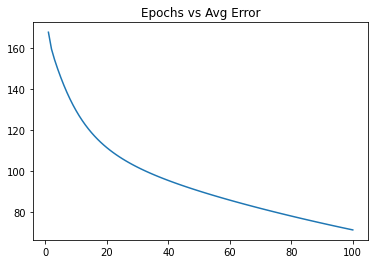

For Classes 1 2


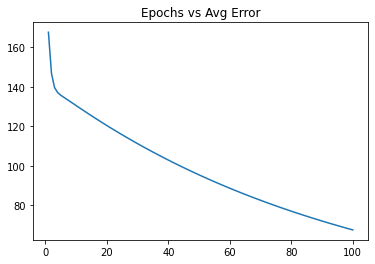

In [107]:
W = multiPerceptron.fit(trainData, 0.0099, 0.033, 100, 3)

In [109]:
W

[[0,
  array([ 2.32039748, -0.1345132 , -3.69662546]),
  array([ 7.42832111, -0.53691186,  2.51422872])],
 [array([ 2.32039748, -0.1345132 , -3.69662546]),
  0,
  array([ 8.90450255, -1.10986803,  0.43411799])],
 [array([ 7.42832111, -0.53691186,  2.51422872]),
  array([ 8.90450255, -1.10986803,  0.43411799]),
  0]]

In [110]:
train_acc , val_acc, test_acc = multiPerceptron.accuracy(W, trainData, 3), multiPerceptron.accuracy(W, valData, 3), multiPerceptron.accuracy(W, testData, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [111]:
print('Train Accuracy: %.2f \nValidation Accuracy: %.2f \nTest Accuracy: %.2f' %(train_acc, val_acc, test_acc))

Train Accuracy: 81.00 
Validation Accuracy: 82.67 
Test Accuracy: 81.33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


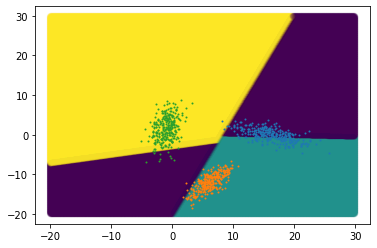

In [108]:
multiPerceptron.decisionPlot(W, -20, 30, 3, trainData)